# Webinar: NASA ORNL DAAC MODIS and VIIRS Data Tools and Services at your Fingertips
-----

*Note 1: Relative links inside the notebook will not work when viewed in GitHub*     
*Note 2: Two dollar signs in one line does odd things to GitHub markdown. Some code outputs contain mysterious tags. Open in jupyter notebook and you will not see these.*

### Table of Contents

[**Introduction**](#Introduction)           
* [**Helpful Links**](#Helpful-Links)           
* [**Prerequisites**](#Prerequisites)           
* [**GET products**](#GET-products)     

[**Get EVI Subsets from MODIS/VIIRS Web Service**](#Get-VIIRS-EVI-Subsets-from-MODIS/VIIRS-Web-Service)     

* [**GET dates**](#GET-dates)                                                                    
* [**GET subset**](#GET-subset)
    * [Capture subset metadata](#Capture-subset-metadata)
    * [Format subset response to familiar structure](#Format-subset-response-to-familiar-structure)
    * [Plot raster grid](#Plot-the-subset-as-a-raster-grid)           


* [**Request a time series**](#Make-a-time-series-from-multiple-subset-requests)                  
* [**Quality filtering**](#Apply-quality-filter-to-the-time-series)                          
    * [Depict workflow as raster grid](#Depict-filtering-workflow-as-raster-grids)             
    
    
* [**Time series by land cover type**](#Time-series-by-land-cover-type)                          
* [**Bonus Content**](#BONUS-CONTENT)                                                            
    * [MOD11A2 QC Table in R](#MOD11A2-QC-Table-in-R)     
    * [VNP15A2H QC Table in R](#VNP15A2H-QC-Table-in-R)              


# Introduction
-----

In this demo, we'll learn how to access the MODIS/VIIRS Web Service using R and efficiently prepare a time series of data for further analysis. The methods in this demo can be applied to subsets that are retrieved through the MODIS/VIIRS Global Subsetting Tool or Web Service.

First, we'll see example usage for the **dates** and **subset** web service functions. Then we'll request a time series of Enhanced Vegetation Index (EVI) from the [**VIIRS Vegetation Indices (VNP13A1)**](https://dx.doi.org/10.5067/VIIRS/VNP13A1.001) product and learn how to apply custom filtering based on user-specified quality criteria.  

To place a MODIS/VIIRS Global Tool Order for the data used in the demo, use the following curl command:
```
curl -X GET --header 'Accept: text/csv' 'https://modis.ornl.gov/rst/api/v1/VNP13A1/subsetOrder?latitude=35.69946&longitude=-83.51339&email=<YOUR@EMAIL.COM>&uid=<MY-ORDER>&startDate=A2012017&endDate=A2018201&kmAboveBelow=2&kmLeftRight=2'
```
But replace ```<MY-ORDER>``` with an ID and ```<YOUR@EMAIL.COM>``` with your email ...

**We will start with this plot EVI that assumes all data quality is satisfactory:**    
<img src="pictures/evi2_unfiltered.png" style="width: 800px;">

**And finish with this plot of filtered EVI that indicates the percentage of pixels meeting our custom quality criteria:**
<img src="pictures/evi2_filtered.png" style="width: 800px;">

**Using a method that looks something like this:**
<img src="pictures/filtering_example.png" style="width: 800px;">
<img src="pictures/raster_grids_filtering_evi2.png" style="width: 800px;">

Then we'll see a short example of how to summarize our EVI time series according to land cover types from the [**MODIS Land Cover (MCD12Q1)**](https://dx.doi.org/10.5067/MODIS/MCD12Q1.006) product.

<img src="pictures/evi2_land_cover_filtered.png" style="width: 800px;">


# Helpful Links
-----

[ORNL DAAC MODIS Webpage](https://modis.ornl.gov/)     
[MODIS Web Service](https://modis.ornl.gov/data/modis_webservice.html)     
[VNP13A1 User Guide](https://lpdaac.usgs.gov/sites/default/files/public/product_documentation/vnp13_user_guide_atbd_v2.1.2.pdf)     
[MCD12Q1 User Guide](https://lpdaac.usgs.gov/sites/default/files/public/product_documentation/mcd12_user_guide_v6.pdf)     

# Prerequisites
-----

**Libraries:**      

* **httr** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for submitting GET requests                   
* **jsonlite** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for parsing JSON response to R data frame     
* **ggplot2, scales, viridis** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for convenient plotting                       

Instead of **jsonlite**, you could use the **readr** library to parse a text response to an R data frame.

In [1]:
# Web service interaction:
library(httr)
library(jsonlite)

# Plots:
library(ggplot2)
library(scales)
library(viridis)
require(gridExtra)

# Rasters:
library(raster)
library(rasterVis)

options(warn=-1)

Loading required package: viridisLite

Attaching package: 'viridis'

The following object is masked from 'package:scales':

    viridis_pal

Loading required package: gridExtra
Loading required package: sp
Loading required package: lattice
Loading required package: latticeExtra
Loading required package: RColorBrewer

Attaching package: 'latticeExtra'

The following object is masked from 'package:ggplot2':

    layer




## GET products
------

Visit the ORNL DAAC MODIS/VIIRS Web Service help page for descriptions and usage examples of each web service function:
https://modis.ornl.gov/data/modis_webservice.html

Set the REST API endpoint and test connectivity using **httr::http_status**.

**GET products:**
https://modis.ornl.gov/rst/api/v1/products

In [2]:
url <- "https://modis.ornl.gov/rst/api/v1/"

response <- GET("https://modis.ornl.gov/rst/api/v1/products")
http_status(response)$message

[1] "Success: (200) OK"

Use **httr::content** to parse the response object to a list. There are other parsing options that may make your life easier depending on your needs. See the [httr documentation](https://cran.r-project.org/web/packages/httr/httr.pdf) on CRAN.

See https://modis.ornl.gov/data/modis_webservice.html for more information about web service functions.

In [3]:
products <- content(response)$products
typeof(products)
products[1]

[1] "list"

[[1]]
[[1]]$product
[1] "Daymet"

[[1]]$description
[1] "Daily Surface Weather Data (Daymet) on a 1-km Grid for North America, Version 3"

[[1]]$frequency
[1] "Daily"

[[1]]$resolution_meters
[1] 1000

# Get VIIRS EVI Subsets from MODIS/VIIRS Web Service

We will submit a subset request for the **VIIRS Enhanced Vegetation Index 2 (VNP13A1)** for a site in Great Smoky Mountains National Park near Gatlinburg, TN (35.71326, -83.51047). Around 11,000 acres burned during the [Chimney Tops 2 Fire](https://www.nps.gov/grsm/learn/news/nps-releases-review-of-chimney-tops-2-fire.htm) in November and December 2016.


## GET dates
------

```https://modis.ornl.gov/rst/api/v1/PRODUCT/dates?latitude=LATITUDE&longitude=LONGITUDE```

The MODIS/VIIRS Web Service has a ten tile limit per request to ensure responsivity of the service and to avoid time outs. We need to make a list of available dates to iterate through while we submit our subset requests. The **dates** function returns a list of available dates for the specified coordinate and MODIS/VIIRS product.

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS/VIIRS product code as listed by **products** function   |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |

The response contains a list of two strings per available MODIS date for the requested MODIS/VIIRS product and coordinate:
* modis_date ("AYYYYDOY")    
* calendar_date ("YYYY-MM-DD")

Get the available dates for VNP13A1 at our site:

In [4]:
# Set dates request parameters
prod <- 'VNP13A1'   # MODIS product
lat <- 35.71326     # Input latitude
lon <- -83.51047    # Input longitude

r <- GET(paste0("https://modis.ornl.gov/rst/api/v1/",prod,"/dates?latitude=",lat,"&longitude=",lon)) # Get dates response
dates <- content(r)$dates # Parse response object to list
modis_dates <- unlist(lapply(dates, function(dt) dt$modis_date)) # Split list of lists into list of modis date strings
calendar_dates <- as.Date(unlist(lapply(dates, function(dt) dt$calendar_date))) # and also into R date objects
doys <- substr(modis_dates,start=6,stop=8) # Also get a list of days of the year

# Print the first ten modis dates
paste(modis_dates[1:10])

[1] "A2012017" "A2012025" "A2012033" "A2012041" "A2012049" "A2012057"
 [7] "A2012065" "A2012073" "A2012081" "A2012089"


## GET subset
------

The **subset** function returns the subset in either json or text/csv format. *kmAboveBelow* and *kmLeftRightight* indicate the number of kilometers above and below, left and right of the center pixel of the subset; e.g. for a 500-m product (MOD09A1) 10, 10 will result in a subset with a spatial extent covering 20.5- x 20.5-km. The subset command takes the following inputs:

| Parameter          | Description                                                   |
|:-------------------|:--------------------------------------------------------------|
| **product**        | MODIS product code as listed by **products**                  |
| **latitude**       | latitude                                                      |
| **longitude**      | longitude                                                     |
| **band**           | band ID as listed by **bands**                                |
| **startDate**      | MODIS start date as listed by **dates** ("AYYYYDOY")          |
| **endDate**        | MODIS end date as listed by **dates** ("AYYYYDOY")            |
| **kmAboveBelow**   | number of kilometers to subset above and below center pixel   |
| **kmLeftRight**    | number of kilometers to subset left and right of center pixel |


The response includes helpful metadata about the subset:

* band --- requested band
* cellsize --- cell size in meters
* header --- request url
* latitude --- latitude of center pixel of subset
* longitude --- longitude of center pixel of subset
* ncols --- number of columns in the subset
* nrows --- number of rows in the subset
* scale --- scale factor
* **subset --- subset data; one per timestep - see below**
* units --- product data units
* xllcorner --- MODIS sinusoidal x-coordinate of the lower left corner of the subset
* yllcorner --- MODIS sinusoidal y-coordinate of the lower left corner of the subset

**The subset data are stored within the subset element of the response. We'll take a look at its contents in the next step.**

In the following code block we set our subset parameters, make a simple function that combines all of them into a URL string, and submit a subset request for the first date in our list:

In [5]:
# Set the remaining subset request parameters
data_band <- '500_m_16_days_EVI2'        # Daytime LST band name
qc_band <- '500_m_16_days_VI_Quality'    # Daytime QC band name
above_below <- 2                         # km above/below
left_right <- 2                          # km left/right

requestURL <- function(latitude, longitude, product, band, start_date, end_date, kmAB, kmLR){
    return(
        paste0(
            url,product,"/subset?",
            "latitude=",latitude,
            "&longitude=",longitude,
            "&band=",band,
            "&startDate=",start_date,
            "&endDate=",end_date,
            "&kmAboveBelow=",kmAB,
            "&kmLeftRight=",kmLR
        )
    )
}

r <- GET(requestURL(lat, lon, prod, data_band, modis_dates[1], modis_dates[1], above_below, left_right))
subset <- fromJSON(toJSON(content(r)))
subset

modis_date,calendar_date,band,tile,proc_date,data
A2012017,2012-01-17,500_m_16_days_EVI2,h11v05,2018137160532,"1920, 2032, 2042, 1744, 1887, 1588, 1588, 1932, 2154, 2048, 1778, 1448, 1493, 1493, 1388, 1698, 2326, 2385, 1593, 1772, 1593, 2186, 1779, 1519, 1760, 2001, 2375, 1922, 2152, 2090, 2090, 1554, 1720, 2169, 1954, 2244, 1497, 1497, 1778, 2060, 1421, 1372, 1501, 1757, 1106, 2426, 2239, 2235, 1814, 1697, 1653, 1621, 1577, 1417, 1812, 1576, 1473, 1686, 2385, 2876, 2059, 2059, 1997, 1767, 2030, 1809, 1694, 900, 1354, 2570, 2024, 1905, 1958, 1958, 2643, 1569, 1128, 1851, 2955, 3292, 2222"


### Capture subset metadata

Save some metadata about our subset to use for plotting raster grids:

In [6]:
nrow <- as.integer(subset$nrow)             # number of rows
ncol <- as.integer(subset$ncol)             # number of columns
xllcorner <- as.double(subset$xllcorner)    # lower left hand corner x-coordinate
yllcorner <- as.double(subset$yllcorner)    # lower left hand corner y-coordinate
cellsize <- as.double(subset$cellsize)      # pixel size
scale <- as.double(subset$scale)            # scale factor

cat(
    "Row count: ",nrow,
    "\nCol count: ",ncol,
    "\nLower left X: ",xllcorner,
    "\nLower left Y: ",yllcorner,
    "\nPixel size: ",cellsize,
    "\nScale factor: ",scale
)

Row count:  9 
Col count:  9 
Lower left X:  -7541804 
Lower left Y:  3969200 
Pixel size:  463.3127 
Scale factor:  1e-04

### Format subset response to familiar structure

We can reformat the time series into a structure more suitable for plotting by converting the **data** column into a data frame and transposing it such that each row is one step in the time series and each column is a pixel. 

The resulting structure matches what we would get by reading a CSV from the Global Tool into a data frame:

In [7]:
# Get subset$subset$data as a new data frame and transpose so that rows are timesteps and columns are pixels
format_subset <- t(as.data.frame(subset$subset$data, col.names=subset$subset$modis_date, check.names=FALSE))
format_subset <- format_subset*as.numeric(scale)
format_subset

A2012017,0.192,0.2032,0.2042,0.1744,0.1887,0.1588,0.1588,0.1932,0.2154,0.2048,...,0.1905,0.1958,0.1958,0.2643,0.1569,0.1128,0.1851,0.2955,0.3292,0.2222


### Plot the subset as a raster grid

Here make a simple function that will make raster objects based on our subset parameters. Then we make a raster object for our subset and plug in the EVI values:

class       : RasterLayer 
dimensions  : 9, 9, 81  (nrow, ncol, ncell)
resolution  : 463.3127, 463.3127  (x, y)
extent      : -7541804, -7537635, 3969200, 3973370  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs 
data source : in memory
names       : layer 
values      : 0.09, 0.3292  (min, max)


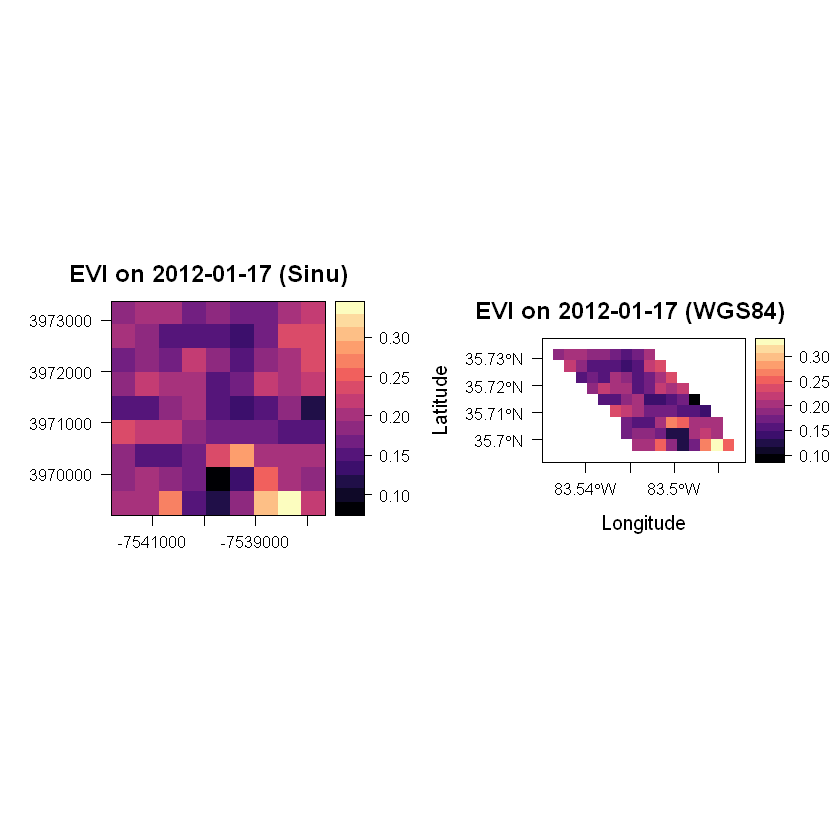

In [8]:
# Make function to create raster objects
r_template <- function(vals, nrow,ncol,xllcorner,yllcorner,cellsize){
    return(
        raster(
            vals = vals,
            nrows = nrow,
            ncols = ncol,
            xmn = xllcorner,
            xmx = xllcorner + (ncol*cellsize),
            ymn = yllcorner,
            ymx = yllcorner + (nrow*cellsize),
            crs = '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ',
            resolution = cellsize 
        )
    )
}

# Use subset metadata and the new function to make raster object
r_subset <- r_template(format_subset, nrow, ncol, xllcorner, yllcorner, cellsize)
# Warp to WGS84 as another raster object
r_subset_wgs84 <- projectRaster(r_subset, crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ')

# Plot both with rasterVis::levelplot
r_ras1 <- levelplot(r_subset, main = paste0("EVI on ",subset$subset$calendar_date," (Sinu)"), margin = FALSE)
r_ras2 <- levelplot(r_subset_wgs84, main = paste0("EVI on ",subset$subset$calendar_date," (WGS84)"), margin = FALSE)

r_subset # Print raster (sinu) details
grid.arrange(r_ras1, r_ras2, ncol=2) # Display raster grids with gridExtra::grid.arrange

# Save raster objects as GeoTIFFs
#writeRaster(r_subset,'sinu_subset.tif',options=c('COMPRESS=LZW'))
#writeRaster(r_subset_wgs84,'wgs84_subset.tif',options=c('COMPRESS=LZW'))

## Make a time series from multiple subset requests
------

Because of the ten tile limit imposed by the web service, we have to submit multiple requests to get a complete time series. 

Use the same input parameters as above and loop through the *dates* variable, submitting requests for the **2-band Enhanced Vegetation Index (500_m_16_days_EVI2)** and **VI Quality (500_m_16_days_VI_Quality)** layers for each timestep:

In [9]:
# Initialize response data.frames to store the returned LST and QC data
proddata <- data.frame()
qcdata <- data.frame()

# Iterate through the list of dates and submit subset requests.
for (dt in modis_dates){
    
    # Submit request and append to LST time series
    r <- GET(requestURL(lat, lon, prod, data_band, dt, dt, above_below, left_right))
    subset <- fromJSON(toJSON(content(r)))
    proddata <- rbind(proddata, subset$subset)
    
    # Submit request and append to QC time series
    r <- GET(requestURL(lat, lon, prod, qc_band, dt, dt, above_below, left_right))
    qcsubset <- fromJSON(toJSON(content(r)))
    qcdata <- rbind(qcdata, qcsubset$subset)

}

Here are the general steps to plot the time series of the subset mean:
1. Reformat the data frame to be "CSV-like" as we did before    
2. Apply the scale factor    
3. Calculate the mean and standard deviation for each timestep as a data frame called **prodstats**   
4. Plot the result

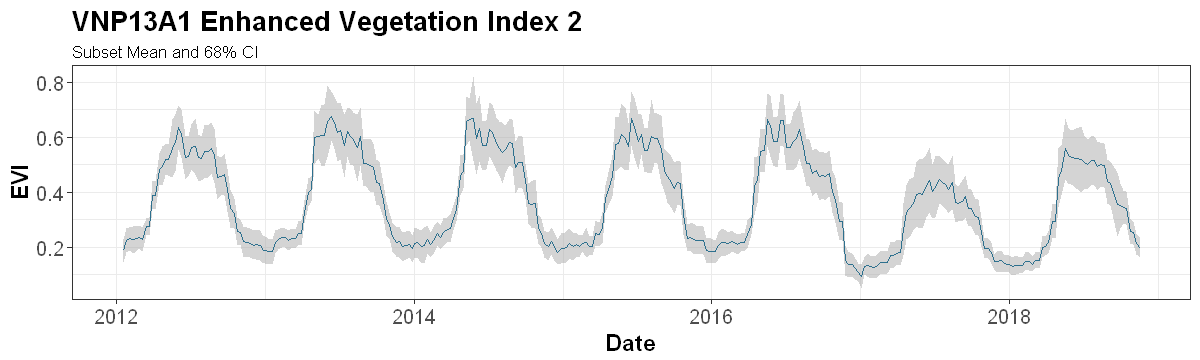

In [10]:
# Make subset data "CSV-like":
prodvalues <- t(as.data.frame(proddata$data, col.names=proddata$calendar_date, check.names=FALSE))
prodvalues <- prodvalues*as.numeric(scale) # Apply scale factor

prodstats <- data.frame( # prodstats data frame is passed to ggplot
    date = as.Date(unlist(calendar_dates)), # get formatted dates from calendar_dates list (strings)
    mean = rowMeans(prodvalues, na.rm=TRUE), # get mean of each row (timestep)
    sd = apply(prodvalues, 1, sd, na.rm = TRUE) # and standard deviation 
)

plot <- ggplot(prodstats) +

    # Plot mean (geom_line) and standard deviation (geom_ribbon)
    geom_ribbon(aes(ymin=prodstats$mean - prodstats$sd, ymax=prodstats$mean + prodstats$sd , x=date), fill = 'darkgray', alpha = 0.5) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF') + # draw the line for the mean value 

    # Label and make the plot pretty:
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

options(repr.plot.width = 10, repr.plot.height = 3)
plot

**We're going to make a table that looks like this:**
<img src="pictures/qc_table_R.png" style="width: 700px;">

## Apply quality filter to the time series
------

So let's figure out what the quality layer values mean. Here is the QC table from the [VNP13A1 User Guide](https://lpdaac.usgs.gov/sites/default/files/public/product_documentation/vnp13_user_guide_atbd_v2.1.2.pdf) (p. 43):

<img src="pictures/VNP13A1_QC.png" style="width: 600px;">

Make new "CSV-like" data frames for the EVI and QC subset data. Then get a vector of unique values from the QC layer time series:

In [11]:
# Create "CSV-like" data frames (prodvalues & qcvalues)
prodvalues <- t(as.data.frame(proddata$data, col.names=proddata$calendar_date, check.names=FALSE))
qcvalues <- t(as.data.frame(qcdata$data, col.names=qcdata$calendar_date, check.names=FALSE))

# Get a vector of unique values from the QC layer time series
qcvals <- sort(unique(c(qcvalues)))
print(paste('These are the unique QC values: ', paste(sort(qcvals), collapse=', '), sep = ''), quote = FALSE)
head(prodvalues,5)
head(qcvalues,5)

[1] These are the unique QC values: 2061, 2065, 2116, 2120, 2124, 2185, 2189, 2257, 2261, 2325, 2445, 2517, 2521, 3358, 3362, 3366, 3418, 18713, 34893, 34961, 34965, 35033, 35037, 35097, 35101, 35105, 35157, 35221, 35225, 35293, 35297, 51229, 51485, 51489, 51493


2012-01-17,1920,2032,2042,1744,1887,1588,1588,1932,2154,2048,...,1905,1958,1958,2643,1569,1128,1851,2955,3292,2222
2012-01-25,2389,2346,2687,2071,2110,2233,2020,2116,2080,2256,...,2856,2151,2434,2643,1569,1755,1851,2955,3292,2222
2012-02-02,2389,2346,2693,2071,2110,2233,2190,2352,2352,2256,...,2856,2151,2434,2734,2955,1755,1944,2870,3422,2685
2012-02-10,2337,2567,2693,2293,2323,2009,2190,2352,2352,2609,...,2811,1617,2655,2646,1571,619,2369,3265,3023,2521
2012-02-18,2280,2506,2684,2293,2223,1791,1644,1903,2444,2509,...,2811,2491,2785,2646,1571,619,2627,3034,3023,2521


2012-01-17,2116,2116,2116,2116,2116,2116,2116,2116,2120,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-01-25,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-02,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-10,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2120,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-18,2116,2116,2116,2116,2116,2120,2120,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116


Make an empty data frame with the following columns:
* **Integer_Value** : populated with unique integers from our QC layer time series (qcvals)    
* **Bit{15-0}** : one column per bit (16 total)     
* **{QC group}** : one column per QC group from the description column of the table above (9 total)   

In [12]:
QC_Data <- data.frame(
    
    # A column with one row for each unique integer value in the QC layer time series
    Integer_Value = qcvals, 
    
    # An empty column for each bit 
    Bit15 = NA, Bit14 = NA, Bit13 = NA, Bit12 = NA, Bit11 = NA, Bit10 = NA, Bit9 = NA, Bit8 = NA, 
    Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, Bit1 = NA, Bit0 = NA, 
    
    # An empty column for each QC group
    MODLAND_QA = NA, VI_usefulness = NA, Aerosol_quantity = NA, Adjacent_cloud_detected = NA,
    Atmosphere_BRDF_correction_performed = NA, Mixed_clouds = NA, Land_Water_flag = NA, 
    Possible_snow_ice = NA, Possible_shadow = NA

)

head(QC_Data, 5)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2065,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2116,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2120,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2124,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Get the binary representation of each integer and populate bit columns, then populate the columns described by the bits:

In [13]:
# Loop through each QC integer and populate the QC bit columns with 0s and 1s
for(i in seq(1,length(QC_Data$Integer_Value),1)){
    AsInt <- as.integer(intToBits(QC_Data[i,])[1:16])
    QC_Data[i,2:17] <- AsInt[16:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$MODLAND_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0 == 0] <- 'VI produced, good quality'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0 == 1] <- 'VI produced, but check other QA'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0 == 0] <- 'Pixel produced, but most probably cloudy'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0 == 1] <- 'Pixel not produced due to other reasons than clouds'

QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 1'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 2'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 3'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 4'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 5'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 6'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 7'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 8'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 9'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 10'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 11'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 12'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 13'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality so low that it is not useful'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'L1B data faulty'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Not useful for any other reason/not processed'

QC_Data$Aerosol_quantity[QC_Data$Bit7 == 0 & QC_Data$Bit6==0] <- 'Climatology'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 0 & QC_Data$Bit6==1] <- 'Low'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 1 & QC_Data$Bit6==0] <- 'Average'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 1 & QC_Data$Bit6==1] <- 'High'

QC_Data$Adjacent_cloud_detected[QC_Data$Bit8 == 0] <- 'No'
QC_Data$Adjacent_cloud_detected[QC_Data$Bit8 == 1] <- 'Yes'

QC_Data$Atmosphere_BRDF_correction_performed[QC_Data$Bit9 == 0] <- 'No'
QC_Data$Atmosphere_BRDF_correction_performed[QC_Data$Bit9 == 1] <- 'Yes'

QC_Data$Mixed_clouds[QC_Data$Bit10 == 0] <- 'No'
QC_Data$Mixed_clouds[QC_Data$Bit10 == 1] <- 'Yes'

QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 0] <- 'Land and desert'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 1] <- 'land no desert'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 1 & QC_Data$Bit11 == 0] <- 'inland water'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 1 & QC_Data$Bit11 == 1] <- 'sea water'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 1 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 1] <- 'coastal'

QC_Data$Possible_snow_ice[QC_Data$Bit14 == 0] <- 'No'
QC_Data$Possible_snow_ice[QC_Data$Bit14 == 1] <- 'Yes'

QC_Data$Possible_shadow[QC_Data$Bit15 == 0] <- 'No'
QC_Data$Possible_shadow[QC_Data$Bit15 == 1] <- 'Yes'

head(QC_Data,5)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 4,Climatology,No,No,No,land no desert,No,No
2065,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 5,Climatology,No,No,No,land no desert,No,No
2116,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 2,Low,No,No,No,land no desert,No,No
2120,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 3,Low,No,No,No,land no desert,No,No
2124,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 4,Low,No,No,No,land no desert,No,No


Now decide what pixels to exclude from the analysis using the information provided in the QC group columns. We'll keep only the rows for integers that represent pixels of unacceptable quality: 

1. **MODLAND_QA** must not be *Pixel produced, but most probably cloudy* or *Pixel not produced due to other reasons than clouds*  
2. **VI_usefulness** must not be *Quality Lv 4 (or worse)*
3. **Aerosol_quantity** must not be *High*
4. **Adjacent_cloud_detected** must not be *Yes*
5. **Possible_shadow** must not be *Yes*

We use the integers from the remaining rows to make a mask from the QC layer at each timestep.

In [14]:
MODLAND_QA <- c('Pixel produced, but most probably cloudy','Pixel not produced due to other reasons than clouds')
VI_usefulness <- c("Quality Lv 4","Quality Lv 5","Quality Lv 6","Quality Lv 7","Quality Lv 8","Quality Lv 9","Quality Lv 10","Quality Lv 11","Quality Lv 12","Quality Lv 13",
                   "Quality so low that it is not useful","L1B data faulty","Not useful for any other reason/not processed")
Aerosol_quantity <- "High"
Adjacent_cloud_detected <- "Yes"
Possible_shadow <- "Yes"

QC_Data <- QC_Data[QC_Data$MODLAND_QA %in% MODLAND_QA | 
                    QC_Data$VI_usefulness %in% VI_usefulness | 
                    QC_Data$Aerosol_quantity == Aerosol_quantity | 
                    QC_Data$Adjacent_cloud_detected == Adjacent_cloud_detected |
                    QC_Data$Possible_shadow == Possible_shadow 
                   ,]
rownames(QC_Data) <- NULL
head(QC_Data,10)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 4,Climatology,No,No,No,land no desert,No,No
2065,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 5,Climatology,No,No,No,land no desert,No,No
2124,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 4,Low,No,No,No,land no desert,No,No
2189,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 4,Average,No,No,No,land no desert,No,No
2257,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 5,High,No,No,No,land no desert,No,No
2261,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 6,High,No,No,No,land no desert,No,No
2325,0,0,0,0,1,0,0,1,0,...,1,"VI produced, but check other QA",Quality Lv 6,Climatology,Yes,No,No,land no desert,No,No
2445,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 4,Average,Yes,No,No,land no desert,No,No
2517,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 6,High,Yes,No,No,land no desert,No,No
2521,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 7,High,Yes,No,No,land no desert,No,No


Now we can filter the data using the remaining integers. Loop through the rows (timesteps) of EVI and QC. For each row:
1. Get the index of every column (pixel) in **qcvalues** that contains a value in the **Integer_Value** column of our final QC table.     
2. Set the values to *NA* in **evivalues** for the indexed columns (pixels).     
 
<img src="pictures/filtering_example.png" style="width: 800px;">


In [15]:
filter <- QC_Data$Integer_Value # We will remove these values

for(tstep in seq(1, length(calendar_dates), by = 1)){ # Loop through timesteps
    filt <- which(qcvalues[tstep,] %in% filter) # Make mask from QC layer
    prodvalues[tstep,filt] <- NA # Set LST columns to NA
    
}

The EVI time series is filtered now! We'll check by plotting again. This time we'll add a couple additional columns (year and day-of-the-year) to our stats table:

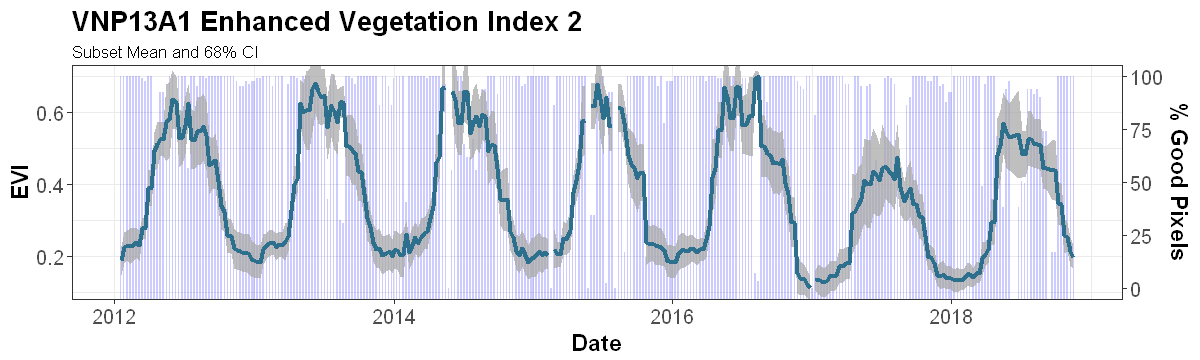

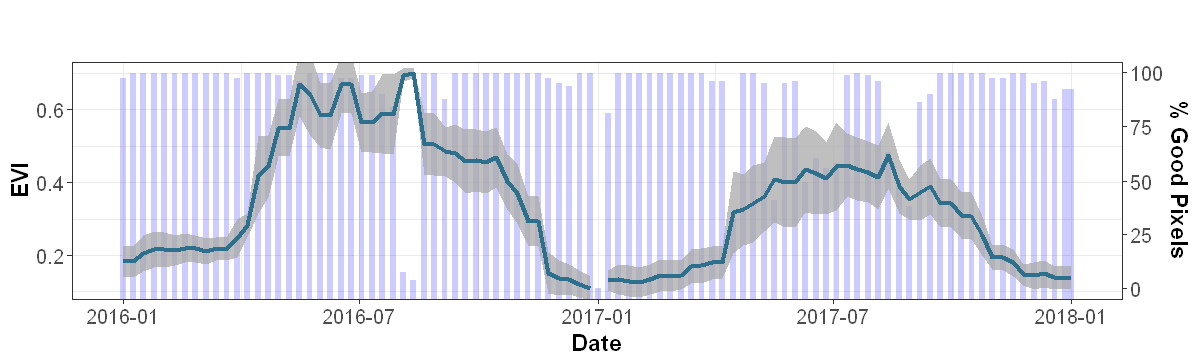

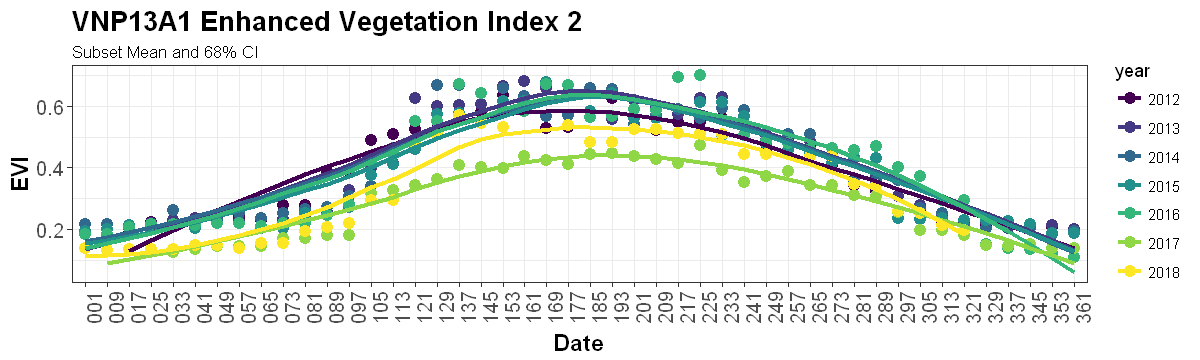

In [16]:
prodvalues <- prodvalues*as.numeric(scale) # Apply scale factor
pltdate <- unlist(calendar_dates)

prodstats <- data.frame(
    date = as.Date(pltdate),
    year = substr(pltdate,start=1,stop=4),
    doy = substr(unlist(modis_dates),start=6,stop=8),
    mean = rowMeans(prodvalues, na.rm=TRUE), 
    sd = apply(prodvalues, 1, sd, na.rm = TRUE),
    quality = apply(prodvalues, 1, function(x) sum(!is.na(x))/(nrow*ncol)*100))
                    
# Get min and max of the calculated means
meanMax <- max(prodstats$mean, na.rm = TRUE)
meanMin <- min(prodstats$mean, na.rm = TRUE)     
# Create simple function to scale the quality values to the mean values for plotting
scaleq <- function(x){((x-0)/(100-0))*(meanMax-meanMin)+meanMin}

# find the 68% confidence intervals around the mean
y1 <- prodstats$mean + prodstats$sd 
y2 <- prodstats$mean - prodstats$sd

plot3 <- ggplot(prodstats) +
    # Data quality
    geom_col(aes(y=scaleq(prodstats$quality), x=date), fill= 'blue', alpha = 0.2) +
    scale_y_continuous(limits = c(meanMin, meanMax), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin)/(meanMax - meanMin))*100, name = "% Good Pixels")) +
                    
    # LST mean and sd
    geom_ribbon(aes(ymin=y2, ymax=y1, x=date), fill = 'darkgray', alpha = 0.75) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF', size=1.2) + # draw the line for the mean value  
    
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

plot5 <- ggplot(prodstats, aes(x=doy, y=mean, color=year)) + 
    scale_color_viridis(discrete=T) + 
    geom_point(size=3) + 
    geom_smooth(aes(group=year), method = 'loess', se=FALSE, size=1.2) + 
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12, angle=90), 
        axis.text.y = element_text(size=12)) # set optional theme elements                  
                    
prodstats2 <- prodstats[prodstats$date %in% pltdate[which(pltdate == '2016-01-01'):which(pltdate == '2018-01-01')],]
meanMax2 <- max(prodstats2$mean, na.rm = TRUE)
meanMin2 <- min(prodstats2$mean, na.rm = TRUE)     
plot4 <- ggplot(prodstats2) +
    # Data quality
    geom_col(aes(y=(((prodstats2$quality-0)/(100-0))*(meanMax2-meanMin2)+meanMin2), x=date), fill= 'blue', alpha = 0.2) +
    scale_y_continuous(limits = c(meanMin2, meanMax2), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin2)/(meanMax2 - meanMin2))*100, name = "% Good Pixels")) +
    # LST mean and sd
    geom_ribbon(aes(ymin=(prodstats2$mean - prodstats2$sd), ymax=(prodstats2$mean + prodstats2$sd), x=date), fill = 'darkgray', alpha = 0.75) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF', size=1.2) + # draw the line for the mean value  
    labs(title = ' ', subtitle = ' ') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements
                    
        
options(repr.plot.width = 10, repr.plot.height = 3)
plot3
plot4
plot5

### Depict filtering workflow as raster grids

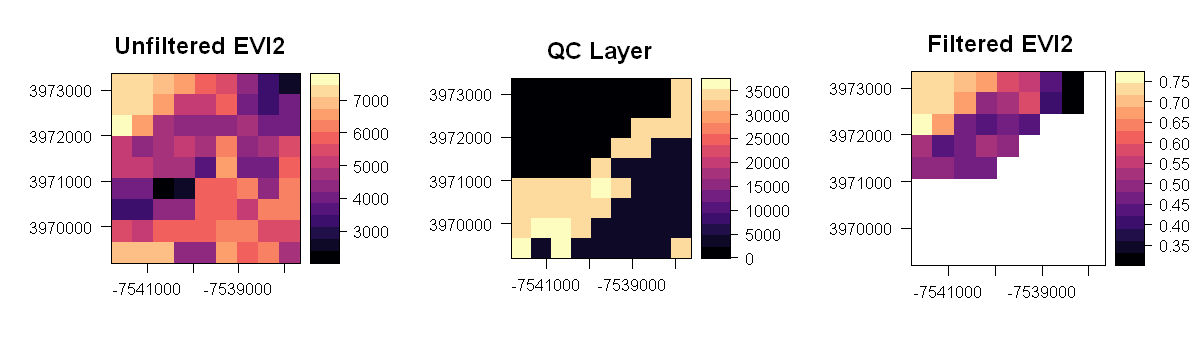

In [17]:
# Get array of unfiltered product values
array_nofilter <- t(as.data.frame(proddata[proddata$calendar_date == "2018-06-26",'data'], check.names=FALSE))
array_nofilter[array_nofilter == 0] <- NA # Remove fill cells
# Get array of QC values
array_qc <- qcvalues["2018-06-26",]
# Get array filtered LST values
array_filter <- prodvalues["2018-06-26",]

# Make a raster object from each array
r_nofilter <- r_template(array_nofilter, nrow, ncol, xllcorner, yllcorner, cellsize)
r_qc <- r_template(array_qc, nrow, ncol, xllcorner, yllcorner, cellsize)
r_filter <- r_template(array_filter, nrow, ncol, xllcorner, yllcorner, cellsize)

# Plot them with rasterVis::levelplot
r1 <- levelplot(r_nofilter, main = "Unfiltered EVI2", margin = FALSE)
r2 <- levelplot(r_qc, main = "QC Layer", margin = FALSE)
r3 <- levelplot(r_filter, main = "Filtered EVI2", margin = FALSE)

# Print them with gridExtra::grid.arrange
grid.arrange(r1, r2, r3, ncol=3)



# Time series by land cover type
-----

The same code we just worked through can be used to calculate a time series for by land cover type. Yes, the Global Tool already does this for you, but only for the classification scheme used by the International Geosphere-Biosphere Programme (IGBP; Type 1). There are several others available in MCD12Q1. You may also want to define your own land cover groupings.

**Code to request the land cover product for our subset area for 2016 and save it:**
```R
# Submit GET request with all the same parameters except for new PRODUCT and BAND
r <- GET(request_url <- requestURL(lat, lon, 'MCD12Q1', 'LC_Type1', "A2016001", "A2016001", above_below, left_right))

# Get response as data frame
lcsubset <- fromJSON(toJSON(content(r)))

# Save the data
saveRDS(lcsubset$subset,file = "data/lcdata.rds")
```

**We'll load the data from a file instead:**

In [18]:
lcdata <- readRDS(file = "data/lcdata.rds")
# Format as "CSV-like" data frame
lcvalues <- t(as.data.frame(lcdata$data, col.names=lcdata$calendar_date, check.names=FALSE))
lcvalues

2016-01-01,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


MCD12Q1 Land Cover Type 1 is the classification scheme used by the International Geosphere-Biosphere Programme (IGBP). Let's make a table:

In [19]:
lctab <- "
Value,LCType,Color
1,Evergreen Needleleaf Forest,#008000
2,Evergreen Broadleaf Forest,#00FF00
3,Deciduous Needleleaf Forest,#99CC00
4,Deciduous Broadleaf Forest,#99FF99
5,Mixed Forests,#339966
6,Closed Shrublands,#993366
7,Open Shrublands,#FFCC99
8,Woody Savannas,#CCFFCC
9,Savannas,#FFCC00
10,Grasslands,#FF9900
11,Permanent Wetlands,#006699
12,Croplands,#FFFF00
13,Urban and Built-Up,#FF0000
14,Cropland/Natural Vegetation Mosaic,#999966
15,Snow and Ice,#FFFFFF
16,Barren or Sparsely Vegetated,#808080
17,Water Bodies,#000080
255,Unclassified,#000000
"
lctab <- read.csv(text = lctab, header = TRUE, stringsAsFactors = FALSE)
lctab

Value,LCType,Color
1,Evergreen Needleleaf Forest,#008000
2,Evergreen Broadleaf Forest,#00FF00
3,Deciduous Needleleaf Forest,#99CC00
4,Deciduous Broadleaf Forest,#99FF99
5,Mixed Forests,#339966
6,Closed Shrublands,#993366
7,Open Shrublands,#FFCC99
8,Woody Savannas,#CCFFCC
9,Savannas,#FFCC00
10,Grasslands,#FF9900


Calculate the mean EVI for each land cover type using a similar masking routine to the QC filtering. Most types won't be present in our subset area:

In [20]:
# Initialize data frame with a column for each land cover type
lcmeans <- data.frame(matrix(ncol = length(unique(lctab$Value)), nrow = 0))
colnames(lcmeans) <- c(lctab$LCType)

# Loop through timesteps
for(tstep in seq(1, length(calendar_dates), by = 1)){
    # Get mean of pixels matching each land cover type for that year and append to lcmeans
    tstepmeans = lapply(lctab$Value, function(type) mean(prodvalues[tstep,][which(lcvalues[1,] %in% type)], na.rm = TRUE))
    lcmeans[tstep,] <- unlist(tstepmeans)
}

# Add Date column to lcmeans
rownames(lcmeans) <- calendar_dates
lcmeans <- lcmeans[,colSums(is.na(lcmeans))<nrow(lcmeans)]
lcmeans$Date <- as.Date(rownames(lcmeans))
                            
head(lcmeans, 5)

,Deciduous Broadleaf Forest,Woody Savannas,Urban and Built-Up,Date
2012-01-17,0.1859762,0.1862000,0.1941667,2012-01-17
2012-01-25,0.2241921,0.2161667,0.2224833,2012-01-25
2012-02-02,0.2329032,0.2114667,0.2258833,2012-02-02
2012-02-10,0.2311365,0.2097667,0.2137667,2012-02-10
2012-02-18,0.2321746,0.2220500,0.2257250,2012-02-18


**Plot it:**

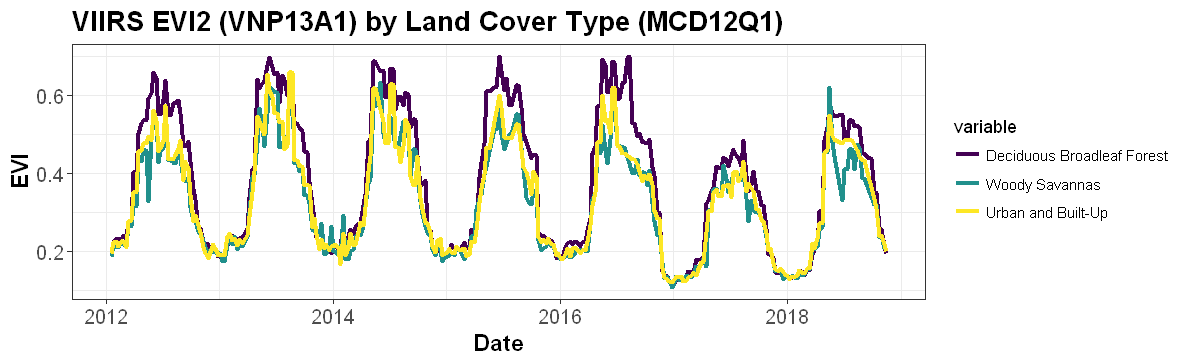

In [21]:
# Use reshape::melt to convert table to long format:
lcmeans_long <- reshape::melt(lcmeans, id.vars="Date")

plot5 <- ggplot(na.omit(lcmeans_long), aes(x = as.Date(Date), y=value, color=variable)) + 
    scale_color_viridis(discrete=T) + 
    geom_line(aes(group=variable), size=1.2) +
    labs(title = 'VIIRS EVI2 (VNP13A1) by Land Cover Type (MCD12Q1)') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(
        plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

plot5


# BONUS CONTENT
-----

### MOD11A2 QC Table in R
Land Surface Temperature/Emissivity

In [22]:
# Create empty data.frame with a row for each possible QC integer value and columns for each bit (8bit)
QC_Data <- data.frame(
    Integer_Value = 0:255, 
    Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, Bit1 = NA, Bit0 = NA, 
    Mandatory_QA = NA, Data_Quality = NA, Emiss_Err = NA, LST_Err = NA
)

# Loop through each QC integer and populate the QC bit columns with 0s and 1s
for(i in QC_Data$Integer_Value){
    AsInt <- as.integer(intToBits(i)[1:8])
    QC_Data[i+1,2:9]<- AsInt[8:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==0] <- 'LST GOOD'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==1] <- 'LST Produced,Other Quality'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==0] <- 'No Pixel,clouds'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==1] <- 'No Pixel, Other QA'

QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==0] <- 'Good Data'
QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==1] <- 'Other Quality'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==0] <- 'TBD'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==1] <- 'TBD'

QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==0] <- 'Emiss Error <= .01'
QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==1] <- 'Emiss Err <=.02'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==0] <- 'Emiss Err <=.04'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==1] <- 'Emiss Err > .04'

QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==0] <- 'LST Err <= 1K'
QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==1] <- 'LST Err <= 3K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==0] <- 'LST Err <= 2K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==1] <- 'LST Err > 3K'

head(QC_Data, 10)

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Error <= .01,LST Err <= 1K
1,0,0,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Error <= .01,LST Err <= 1K
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
3,0,0,0,0,0,0,1,1,"No Pixel, Other QA",Good Data,Emiss Error <= .01,LST Err <= 1K
4,0,0,0,0,0,1,0,0,LST GOOD,Other Quality,Emiss Error <= .01,LST Err <= 1K
5,0,0,0,0,0,1,0,1,"LST Produced,Other Quality",Other Quality,Emiss Error <= .01,LST Err <= 1K
6,0,0,0,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Error <= .01,LST Err <= 1K
7,0,0,0,0,0,1,1,1,"No Pixel, Other QA",Other Quality,Emiss Error <= .01,LST Err <= 1K
8,0,0,0,0,1,0,0,0,LST GOOD,TBD,Emiss Error <= .01,LST Err <= 1K
9,0,0,0,0,1,0,0,1,"LST Produced,Other Quality",TBD,Emiss Error <= .01,LST Err <= 1K


**Example filtering criteria for MOD11A2:**

In [23]:
Mandatory_QA <- "No Pixel,clouds"
LST_Err <- c("LST Err <= 1K","LST Err <= 2K")

QC_Data <- QC_Data[!(QC_Data$LST_Err %in% LST_Err) | QC_Data$Mandatory_QA == Mandatory_QA,]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
6,0,0,0,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Error <= .01,LST Err <= 1K
10,0,0,0,0,1,0,1,0,"No Pixel,clouds",TBD,Emiss Error <= .01,LST Err <= 1K
14,0,0,0,0,1,1,1,0,"No Pixel,clouds",TBD,Emiss Error <= .01,LST Err <= 1K
18,0,0,0,1,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <=.02,LST Err <= 1K
22,0,0,0,1,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Err <=.02,LST Err <= 1K
26,0,0,0,1,1,0,1,0,"No Pixel,clouds",TBD,Emiss Err <=.02,LST Err <= 1K
30,0,0,0,1,1,1,1,0,"No Pixel,clouds",TBD,Emiss Err <=.02,LST Err <= 1K
34,0,0,1,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Err <=.04,LST Err <= 1K
38,0,0,1,0,0,1,1,0,"No Pixel,clouds",Other Quality,Emiss Err <=.04,LST Err <= 1K


### VNP15A2H QC Table in R
Leaf Area Index/Fraction of Photosynthetically Active Radiation

In [24]:
# Create empty data.frame with a row for each possible QC integer value and columns for each bit (8bit)
QC_Data <- data.frame(
    Integer_Value = 0:255, Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, 
    Bit1 = NA, Bit0 = NA, SCF_QC = NA, DeadDetector = NA, BiomeType = NA
)

# Loop through each QC integer and populate the QC bit columns with 0s and 1s
for(i in seq(1,length(QC_Data$Integer_Value),1)){
    AsInt <- as.integer(intToBits(QC_Data[i,])[1:8])
    QC_Data[i,2:9]<- AsInt[8:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$SCF_QC[QC_Data$Bit2 == 0 & QC_Data$Bit1 == 0 & QC_Data$Bit0==0] <- 'Main (RT) method used, best result possible (no saturation)'
QC_Data$SCF_QC[QC_Data$Bit2 == 0 & QC_Data$Bit1 == 0 & QC_Data$Bit0==1] <- 'Main (RT) method used with saturation. Good, very usable'
QC_Data$SCF_QC[QC_Data$Bit2 == 0 & QC_Data$Bit1 == 1 & QC_Data$Bit0==0] <- 'Main (RT) method failed due to bad geometry, empirical algorithm used'
QC_Data$SCF_QC[QC_Data$Bit2 == 0 & QC_Data$Bit1 == 1 & QC_Data$Bit0==1] <- 'Main (RT) method failed due to problems other than geometry, empirical algorithm used'
QC_Data$SCF_QC[QC_Data$Bit2 == 1 & QC_Data$Bit1 == 0 & QC_Data$Bit0==0] <- 'Pixel not produced at all, value could not be retrieved (possible reasons: bad L1B data, unusable VNP09GA data, waterpixel)'

QC_Data$DeadDetector[QC_Data$Bit3 == 0] <- 'Both red and NIR detectors are fine'
QC_Data$DeadDetector[QC_Data$Bit3 == 1] <- 'At least one band has dead detector'

QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==0 & QC_Data$Bit5==0 & QC_Data$Bit4==0] <- 'Water'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==0 & QC_Data$Bit5==0 & QC_Data$Bit4==1] <- 'Grasses/cereal crops'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==0 & QC_Data$Bit5==1 & QC_Data$Bit4==0] <- 'Shrubs'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==0 & QC_Data$Bit5==1 & QC_Data$Bit4==1] <- 'Broadleaf crops'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==1 & QC_Data$Bit5==0 & QC_Data$Bit4==0] <- 'Savanna'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==1 & QC_Data$Bit5==0 & QC_Data$Bit4==1] <- 'Evergreen broadleaf forest'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==1 & QC_Data$Bit5==1 & QC_Data$Bit4==0] <- 'Deciduous broadleaf forest'
QC_Data$BiomeType[QC_Data$Bit7==0 & QC_Data$Bit6==1 & QC_Data$Bit5==1 & QC_Data$Bit4==1] <- 'Evergreen needleleaf forest'
QC_Data$BiomeType[QC_Data$Bit7==1 & QC_Data$Bit6==0 & QC_Data$Bit5==0 & QC_Data$Bit4==0] <- 'Deciduous needleleaf forest'
QC_Data$BiomeType[QC_Data$Bit7==1 & QC_Data$Bit6==0 & QC_Data$Bit5==0 & QC_Data$Bit4==1] <- 'Non-vegetated'
QC_Data$BiomeType[QC_Data$Bit7==1 & QC_Data$Bit6==0 & QC_Data$Bit5==1 & QC_Data$Bit4==0] <- 'Urban'
QC_Data$BiomeType[QC_Data$Bit7==1 & QC_Data$Bit6==0 & QC_Data$Bit5==1 & QC_Data$Bit4==1] <- 'Unclassified'
QC_Data$BiomeType[QC_Data$Bit7==1 & QC_Data$Bit6==1 & QC_Data$Bit5==0 & QC_Data$Bit4==0] <- 'Fill Value'

head(QC_Data, 10)

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,SCF_QC,DeadDetector,BiomeType
0,0,0,0,0,0,0,0,0,"Main (RT) method used, best result possible (no saturation)",Both red and NIR detectors are fine,Water
1,0,0,0,0,0,0,0,1,"Main (RT) method used with saturation. Good, very usable",Both red and NIR detectors are fine,Water
2,0,0,0,0,0,0,1,0,"Main (RT) method failed due to bad geometry, empirical algorithm used",Both red and NIR detectors are fine,Water
3,0,0,0,0,0,0,1,1,"Main (RT) method failed due to problems other than geometry, empirical algorithm used",Both red and NIR detectors are fine,Water
4,0,0,0,0,0,1,0,0,"Pixel not produced at all, value could not be retrieved (possible reasons: bad L1B data, unusable VNP09GA data, waterpixel)",Both red and NIR detectors are fine,Water
5,0,0,0,0,0,1,0,1,NA,Both red and NIR detectors are fine,Water
6,0,0,0,0,0,1,1,0,NA,Both red and NIR detectors are fine,Water
7,0,0,0,0,0,1,1,1,NA,Both red and NIR detectors are fine,Water
8,0,0,0,0,1,0,0,0,"Main (RT) method used, best result possible (no saturation)",At least one band has dead detector,Water
9,0,0,0,0,1,0,0,1,"Main (RT) method used with saturation. Good, very usable",At least one band has dead detector,Water


#### Example filtering criteria for VNP15A2H:

In [25]:
SCF_QC <- c('Main (RT) method used, best result possible (no saturation)','Main (RT) method used with saturation. Good, very usable')
BiomeType <- c('Broadleaf crops','Grasses/cereal crops')

QC_Data <- QC_Data[!(QC_Data$BiomeType %in% BiomeType) | !(QC_Data$SCF_QC %in% SCF_QC),]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,SCF_QC,DeadDetector,BiomeType
0,0,0,0,0,0,0,0,0,"Main (RT) method used, best result possible (no saturation)",Both red and NIR detectors are fine,Water
1,0,0,0,0,0,0,0,1,"Main (RT) method used with saturation. Good, very usable",Both red and NIR detectors are fine,Water
2,0,0,0,0,0,0,1,0,"Main (RT) method failed due to bad geometry, empirical algorithm used",Both red and NIR detectors are fine,Water
3,0,0,0,0,0,0,1,1,"Main (RT) method failed due to problems other than geometry, empirical algorithm used",Both red and NIR detectors are fine,Water
4,0,0,0,0,0,1,0,0,"Pixel not produced at all, value could not be retrieved (possible reasons: bad L1B data, unusable VNP09GA data, waterpixel)",Both red and NIR detectors are fine,Water
5,0,0,0,0,0,1,0,1,NA,Both red and NIR detectors are fine,Water
6,0,0,0,0,0,1,1,0,NA,Both red and NIR detectors are fine,Water
7,0,0,0,0,0,1,1,1,NA,Both red and NIR detectors are fine,Water
8,0,0,0,0,1,0,0,0,"Main (RT) method used, best result possible (no saturation)",At least one band has dead detector,Water
9,0,0,0,0,1,0,0,1,"Main (RT) method used with saturation. Good, very usable",At least one band has dead detector,Water
